# Hyperparameter tuning for LGB

### Import library

In [ ]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer
import random
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

import matplotlib.pyplot as plt
%matplotlib inline

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold
# MAX_EVALS = 500 
MAX_EVALS = 500
N_FOLDS = 10

# bayesian opt
from hyperopt import hp
from hyperopt import tpe
from hyperopt.pyll.stochastic import sample
from hyperopt import Trials
from hyperopt import fmin

### Read in data and separate into training and testing sets

In [ ]:
data = pd.read_csv('/content/caravan-insurance-challenge.csv')
train = data[data['ORIGIN'] == 'train']
test = data[data['ORIGIN'] == 'test']

# Extract the labels and format properly
train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns = ['ORIGIN', 'CARAVAN'])
test = test.drop(columns = ['ORIGIN', 'CARAVAN'])

# Convert to numpy array for splitting in cross validation
features = np.array(train)
test_features = np.array(test)
labels = train_labels[:]

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)
train.head()

Train shape:  (5822, 85)
Test shape:  (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


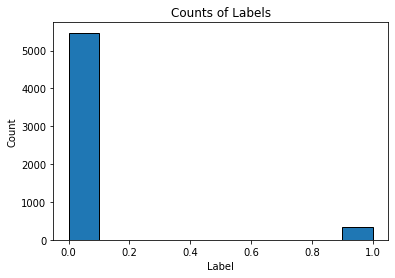

In [ ]:
plt.hist(labels, edgecolor = 'k'); 
plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Counts of Labels');

### Model with default hyperparameters

In [ ]:
model = lgb.LGBMClassifier()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
start = timer()
model.fit(features, labels)
train_time = timer() - start

predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))


The baseline score on the test set is 0.7092.
The baseline training time is 0.2939 seconds


### Hyperparameter grid

In [ ]:
param_grid = {
    'class_weight': [None, 'balanced'],
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

### Randomly sample parameters for gbm

In [ ]:
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.6444444444444444,
 'learning_rate': 0.03953863309933855,
 'min_child_samples': 210,
 'num_leaves': 59,
 'reg_alpha': 0.32653061224489793,
 'reg_lambda': 0.8775510204081632,
 'subsample_for_bin': 40000}

### Create a lgb dataset

In [ ]:
train_set = lgb.Dataset(features, label = labels)

### Perform cross validation with 10 folds

In [ ]:
r = lgb.cv(params, train_set, num_boost_round = 100, nfold = 10, metrics = 'auc', verbose_eval = False, seed = 50)

# Highest score
r_best = np.max(r['auc-mean'])

# Standard deviation of best score
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.76053 with std of 0.04667.
The ideal number of iterations was 25.


In [ ]:
predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

### Dataframe to hold cv results

In [ ]:
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))

### Objective function for random search

In [ ]:
def random_objective(params, iteration, n_folds = N_FOLDS):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 100, nfold = n_folds, 
                        metrics = 'auc', seed = 50)
    end = timer()
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    # Return list of results
    return [loss, params, iteration, n_estimators, end - start]

### Running ramdom search

In [ ]:
random.seed(50)

# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    # Randomly sample parameters for gbm
    print("Iteration: ", i+1)
    params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
    
    print(params)
    
    if params['boosting_type'] == 'goss':
        # Cannot subsample with goss
        params['subsample'] = 1.0
    else:
        # Subsample supported for gdbt and dart
        params['subsample'] = random.sample(subsample_dist, 1)[0]
        
        
    results_list = random_objective(params, i)
    
    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

Iteration:  1
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 76, 'learning_rate': 0.055533968216953146, 'subsample_for_bin': 80000, 'min_child_samples': 460, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 1.0, 'colsample_bytree': 0.8222222222222222}
Iteration:  2
{'class_weight': None, 'boosting_type': 'dart', 'num_leaves': 70, 'learning_rate': 0.011646863384981408, 'subsample_for_bin': 220000, 'min_child_samples': 375, 'reg_alpha': 0.1020408163265306, 'reg_lambda': 0.18367346938775508, 'colsample_bytree': 0.8222222222222222}
Iteration:  3
{'class_weight': 'balanced', 'boosting_type': 'goss', 'num_leaves': 58, 'learning_rate': 0.010197109660117238, 'subsample_for_bin': 40000, 'min_child_samples': 230, 'reg_alpha': 0.7755102040816326, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.8666666666666667}
Iteration:  4
{'class_weight': None, 'boosting_type': 'gbdt', 'num_leaves': 118, 'learning_rate': 0.048981732603349946, 'subsample_for_bin': 280000, 'min_child_s

In [ ]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = True, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params,iteration,estimators,time
0,0.235492,"{'class_weight': 'balanced', 'boosting_type': ...",284,85,2.336585
1,0.236641,"{'class_weight': None, 'boosting_type': 'dart'...",107,100,2.221347
2,0.236871,"{'class_weight': None, 'boosting_type': 'dart'...",58,100,2.167675
3,0.237046,"{'class_weight': 'balanced', 'boosting_type': ...",36,85,2.203272
4,0.237181,"{'class_weight': 'balanced', 'boosting_type': ...",260,100,2.246852


In [ ]:
random_results.loc[0, 'params']

{'boosting_type': 'dart',
 'class_weight': 'balanced',
 'colsample_bytree': 0.6444444444444444,
 'learning_rate': 0.10636616732547971,
 'min_child_samples': 280,
 'num_leaves': 72,
 'reg_alpha': 0.5918367346938775,
 'reg_lambda': 0.9795918367346939,
 'subsample': 0.8232323232323233,
 'subsample_for_bin': 280000}

### Find the best parameters and number of estimators

In [ ]:
best_random_params = random_results.loc[0, 'params'].copy()
best_random_estimators = int(random_results.loc[0, 'estimators'])
best_random_model = lgb.LGBMClassifier(n_estimators=best_random_estimators, n_jobs = -1, 
                                       objective = 'binary', **best_random_params, random_state = 50)

# Fit on the training data
best_random_model.fit(features, labels)

# Make test predictions
predictions = best_random_model.predict_proba(test_features)[:, 1]


print('The best model from random search scores {:.4f} on the test data.'.format(roc_auc_score(test_labels, predictions)))
print('This was achieved using {} search iterations.'.format(random_results.loc[0, 'iteration']))

The best model from random search scores 0.7250 on the test data.
This was achieved using 284 search iterations.


In [ ]:
random_results.to_csv('random_caravan_lgb.csv')

## Tunning using Bayesian optimization

In [ ]:
def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 100, nfold = n_folds, 
                        metrics = 'auc', seed = 50)
    
    run_time = timer() - start
    
    # Extract the best score
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

#### Create the learning rate

In [ ]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

#### boosting type domain 

In [ ]:
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
params = sample(boosting_type)
params

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.7409580574672209}}

#### Define the search space

In [ ]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}

In [ ]:
space

{'boosting_type': <hyperopt.pyll.base.Apply at 0x7f4709272090>,
 'class_weight': <hyperopt.pyll.base.Apply at 0x7f470925a790>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7f4709371210>,
 'learning_rate': <hyperopt.pyll.base.Apply at 0x7f47092726d0>,
 'min_child_samples': <hyperopt.pyll.base.Apply at 0x7f470b44b5d0>,
 'num_leaves': <hyperopt.pyll.base.Apply at 0x7f4709272a90>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x7f47093455d0>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x7f4709359510>,
 'subsample_for_bin': <hyperopt.pyll.base.Apply at 0x7f4709272150>}

#### Sample from the full space

In [ ]:
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8540736516002598,
 'learning_rate': 0.01609300921070659,
 'min_child_samples': 270.0,
 'num_leaves': 131.0,
 'reg_alpha': 0.23629347191623518,
 'reg_lambda': 0.05534013010383987,
 'subsample': 0.6170354179908204,
 'subsample_for_bin': 260000.0}

In [ ]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'goss',
 'class_weight': 'balanced',
 'colsample_bytree': 0.967883513129898,
 'learning_rate': 0.010164777570620367,
 'min_child_samples': 350.0,
 'num_leaves': 118.0,
 'reg_alpha': 0.3617330382067684,
 'reg_lambda': 0.5425455524688315,
 'subsample': 1.0,
 'subsample_for_bin': 20000.0}

#### Optimization algorithm

In [ ]:
tpe_algorithm = tpe.suggest

In [ ]:
# Keep track of results
bayes_trials = Trials()

In [ ]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [ ]:
# Global variable
global  ITERATION

ITERATION = 0

### Run optimization

In [ ]:
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 500/500 [14:07<00:00,  1.69s/it, best loss: 0.2314870604562298]


In [ ]:
# Sort the trials with lowest loss (highest AUC) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'estimators': 79,
  'iteration': 439,
  'loss': 0.2314870604562298,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.6957294641173832,
   'learning_rate': 0.03189034372107593,
   'min_child_samples': 210,
   'num_leaves': 64,
   'reg_alpha': 0.6509724723549177,
   'reg_lambda': 0.2936899358728862,
   'subsample': 0.739723306775653,
   'subsample_for_bin': 200000},
  'status': 'ok',
  'train_time': 1.420786992000103},
 {'estimators': 72,
  'iteration': 83,
  'loss': 0.23157350387278575,
  'params': {'boosting_type': 'gbdt',
   'class_weight': None,
   'colsample_bytree': 0.706175050890931,
   'learning_rate': 0.03846123550001267,
   'min_child_samples': 210,
   'num_leaves': 110,
   'reg_alpha': 0.5441773884605038,
   'reg_lambda': 0.034232674562218846,
   'subsample': 0.7449989536417149,
   'subsample_for_bin': 60000},
  'status': 'ok',
  'train_time': 1.4907618770000681}]

In [ ]:
results = pd.read_csv('gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.231487,"{'boosting_type': 'gbdt', 'class_weight': None...",439,79,1.420787
1,0.231574,"{'boosting_type': 'gbdt', 'class_weight': None...",83,72,1.490762
2,0.232837,"{'boosting_type': 'gbdt', 'class_weight': None...",498,100,1.332803
3,0.232907,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",217,98,1.428482
4,0.233013,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",167,100,1.384389


In [ ]:
import ast
# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6957294641173832,
 'learning_rate': 0.03189034372107593,
 'min_child_samples': 210,
 'num_leaves': 64,
 'reg_alpha': 0.6509724723549177,
 'reg_lambda': 0.2936899358728862,
 'subsample': 0.739723306775653,
 'subsample_for_bin': 200000}

### Extract the ideal number of estimators and hyperparameters

In [ ]:
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(features, labels)

LGBMClassifier(colsample_bytree=0.6957294641173832,
               learning_rate=0.03189034372107593, min_child_samples=210,
               n_estimators=79, num_leaves=64, objective='binary',
               random_state=50, reg_alpha=0.6509724723549177,
               reg_lambda=0.2936899358728862, subsample=0.739723306775653)

### Evaluate on the testing data 

In [ ]:
preds = best_bayes_model.predict_proba(test_features)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(test_labels, preds)))
print('This was achieved after {} search iterations'.format(results.loc[0, 'iteration']))

The best model from Bayes optimization scores 0.72758 AUC ROC on the test set.
This was achieved after 439 search iterations
